# Compass Pseudobulking

The runtime of Compass may become prohibitively long for large-scale single-cell RNA-seq datasets. To mitigate this issue, we suggest that users perform pseudobulking on the data before running Compass. This notebook demonstrates how pseudobulking can be performed and runs Compass on pseudobulked data.

The dataset used in this tutorial is from *Smillie, C. S. et al. Intra- and inter-cellular rewiring of the human colon during ulcerative colitis. Cell 178, 714–730.e22 (2019)* ([link](https://www.sciencedirect.com/science/article/pii/S0092867419307329)). You can download the expression data from the [Single Cell Portal](https://portals.broadinstitute.org/single_cell/study/SCP259).

The files you need are:

**Metadata**
- all.meta2.txt

**Epithelial data**

- Epi.genes.tsv
- Epi.barcodes2.tsv
- gene_sorted-Epi.matrix.mtx

**Stromal data**

- Fib.genes.tsv
- Fib.barcodes2.tsv
- gene_sorted-Fib.matrix.mtx

**Immune data**

- Imm.genes.tsv
- Imm.barcodes2.tsv
- gene_sorted-Imm.matrix.mtx

Also download the `cell_subsets.txt` file from the [GitHub repo](https://github.com/cssmillie/ulcerative_colitis/blob/master/cell_subsets.txt) provided by this study.

Place the aforementioned files in the same directory as this notebook.

## Requirements

All of the required python packages can be installed using a cell at the start of the notebook. To install the required python packages, you can uncomment the “install_reqs()” call.

In [1]:
def install_reqs():
  !pip install pandas
  !pip install matplotlib
  !pip install numpy
  !pip install scipy
  !pip install anndata
  !pip install scanpy
#install_reqs()

## Pseudobulking

This section of the tutorial will demonstrate how to perform pseudobulking on a large scRNA-seq dataset. If you already have an AnnData object that you can process directly, you may move on to [this section](#anndata-target).

In [1]:
import pandas as pd
import numpy as np
from scipy.io import mmread
from scipy import sparse
from scipy.sparse import csr_matrix, vstack
import os
import matplotlib.pyplot as plt
import scipy.stats

import anndata as ad
import scanpy as sc

In [4]:
DATA_DIR = '/data/yosef2/scratch/users/charleschien101/ibd_data'

We read in the metadata file here. We will be performing pseudobulking based on the `Health`, `Sample`, and `Cluster` columns.

In [5]:
meta = pd.read_csv(os.path.join(DATA_DIR, 'all.meta2.txt'), sep='\t')
meta

/tmp/ipykernel_3446261/4143661995.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(os.path.join(DATA_DIR, 'all.meta2.txt'), sep='\t')


,NAME,Cluster,nGene,nUMI,Subject,Health,Location,Sample
0,TYPE,group,numeric,numeric,group,group,group,group
1,N7.EpiA.AAACATACACACTG,TA 1,328,891,N7,Non-inflamed,Epi,N7.EpiA
2,N7.EpiA.AAACCGTGCATCAG,TA 1,257,663,N7,Non-inflamed,Epi,N7.EpiA
3,N7.EpiA.AAACGCACAATCGC,TA 2,300,639,N7,Non-inflamed,Epi,N7.EpiA
4,N7.EpiA.AAAGATCTAACCGT,Enterocyte Progenitors,250,649,N7,Non-inflamed,Epi,N7.EpiA
...,...,...,...,...,...,...,...,...
365488,N110.LPB.TTTGGTTAGGATGGTC,Macrophages,635,1366,N110,Inflamed,LP,N110.LPB
365489,N110.LPB.TTTGGTTCACCTCGTT,Plasma,610,2730,N110,Inflamed,LP,N110.LPB
365490,N110.LPB.TTTGGTTTCGGAAACG,Macrophages,859,1979,N110,Inflamed,LP,N110.LPB
365491,N110.LPB.TTTGTCAGTTGACGTT,Macrophages,965,2696,N110,Inflamed,LP,N110.LPB


The `Cluster` column corresponds to various cell types. Since the cell types provided in the `Cluster` column is rather fine-grained, we used the more coarse-grained cell types provided in the `cell_subsets.txt` file.

In [6]:
cell_subsets = pd.read_csv(os.path.join(DATA_DIR, 'cell_subsets.txt'), sep='\t', names=['Cluster', 'CellType'], header=None)
cell_subsets.head()

,Cluster,CellType
0,Stem,Epithelial
1,TA 1,Epithelial
2,TA 2,Epithelial
3,Cycling TA,Epithelial
4,Immature Enterocytes 1,Epithelial


The dataset used in this notebook separately stores expression data for epithelial cells, stromal cells, and immune cells. Here we read in the barcodes (cell names), gene names, and expression matrix.

In [7]:
epi_barcodes = pd.read_csv(os.path.join(DATA_DIR, 'Epi.barcodes2.tsv'), sep='\t', names=['barcodes'], header=None)
fib_barcodes = pd.read_csv(os.path.join(DATA_DIR, 'Fib.barcodes2.tsv'), sep='\t', names=['barcodes'], header=None)
imm_barcodes = pd.read_csv(os.path.join(DATA_DIR, 'Imm.barcodes2.tsv'), sep='\t', names=['barcodes'], header=None)

In [8]:
epi_genes = pd.read_csv(os.path.join(DATA_DIR, 'Epi.genes.tsv'), sep='\t', names=['genes'], header=None)
fib_genes = pd.read_csv(os.path.join(DATA_DIR, 'Fib.genes.tsv'), sep='\t', names=['genes'], header=None)
imm_genes = pd.read_csv(os.path.join(DATA_DIR, 'Imm.genes.tsv'), sep='\t', names=['genes'], header=None)

In [9]:
epi_matrix = (mmread(os.path.join(DATA_DIR, 'gene_sorted-Epi.matrix.mtx')))
epi_matrix

<20028x123006 sparse matrix of type '<class 'numpy.int64'>'
	with 174423911 stored elements in COOrdinate format>

In [10]:
fib_matrix = (mmread(os.path.join(DATA_DIR, 'gene_sorted-Fib.matrix.mtx')))
fib_matrix

<19076x31872 sparse matrix of type '<class 'numpy.int64'>'
	with 39087919 stored elements in COOrdinate format>

In [11]:
imm_matrix = (mmread(os.path.join(DATA_DIR, 'gene_sorted-Imm.matrix.mtx')))
imm_matrix

<20529x210614 sparse matrix of type '<class 'numpy.int64'>'
	with 173255714 stored elements in COOrdinate format>

Since the three expression matrices contain different numbers of genes, we need to fill in the missing gene expression data (with zeros) to be able to integrate the three datasets together. We also create AnnData objects from the expression data for easier data manipulation. If you are not familiar with AnnData objects, you can refer to [the AnnData documentation](https://anndata.readthedocs.io/en/latest/).

In [12]:
all_genes = list(set.union(set(epi_genes['genes']), set(fib_genes['genes']), set(imm_genes['genes'])))
len(all_genes)

21784

In [13]:
epi_matrix_zeros = csr_matrix(np.zeros([len(all_genes) - epi_matrix.shape[0], epi_matrix.shape[1]]), dtype=np.int64)
epi_matrix_combined = vstack((epi_matrix, epi_matrix_zeros))
epi_matrix_combined

<21784x123006 sparse matrix of type '<class 'numpy.int64'>'
	with 174423911 stored elements in COOrdinate format>

In [14]:
epi_remaining_genes = list(set(all_genes) - set(epi_genes['genes']))
len(epi_remaining_genes)

1756

In [15]:
epi_adata = ad.AnnData(epi_matrix_combined.tocsr().transpose())
epi_adata.obs_names = list(epi_barcodes['barcodes'])
epi_adata.var_names = list(epi_genes['genes']) + epi_remaining_genes
epi_adata = epi_adata[:, epi_adata.var_names.sort_values()]
epi_adata

View of AnnData object with n_obs × n_vars = 123006 × 21784

In [16]:
fib_matrix_zeros = csr_matrix(np.zeros([len(all_genes) - fib_matrix.shape[0], fib_matrix.shape[1]]), dtype=np.int64)
fib_matrix_combined = vstack((fib_matrix, fib_matrix_zeros))
fib_matrix_combined

<21784x31872 sparse matrix of type '<class 'numpy.int64'>'
	with 39087919 stored elements in COOrdinate format>

In [17]:
fib_remaining_genes = list(set(all_genes) - set(fib_genes['genes']))
len(fib_remaining_genes)

2708

In [18]:
fib_adata = ad.AnnData(fib_matrix_combined.tocsr().transpose())
fib_adata.obs_names = list(fib_barcodes['barcodes'])
fib_adata.var_names = list(fib_genes['genes']) + fib_remaining_genes
fib_adata = fib_adata[:, fib_adata.var_names.sort_values()]
fib_adata

View of AnnData object with n_obs × n_vars = 31872 × 21784

In [19]:
imm_matrix_zeros = csr_matrix(np.zeros([len(all_genes) - imm_matrix.shape[0], imm_matrix.shape[1]]), dtype=np.int64)
imm_matrix_combined = vstack((imm_matrix, imm_matrix_zeros))
imm_matrix_combined

<21784x210614 sparse matrix of type '<class 'numpy.int64'>'
	with 173255714 stored elements in COOrdinate format>

In [20]:
imm_remaining_genes = list(set(all_genes) - set(imm_genes['genes']))
len(imm_remaining_genes)

1255

In [21]:
imm_adata = ad.AnnData(imm_matrix_combined.tocsr().transpose())
imm_adata.obs_names = list(imm_barcodes['barcodes'])
imm_adata.var_names = list(imm_genes['genes']) + imm_remaining_genes
imm_adata = imm_adata[:, imm_adata.var_names.sort_values()]
imm_adata

View of AnnData object with n_obs × n_vars = 210614 × 21784

In [22]:
epi_var_names = list(epi_adata.var_names)
fib_var_names = list(fib_adata.var_names)
imm_var_names = list(imm_adata.var_names)

assert epi_var_names == fib_var_names
assert epi_var_names == imm_var_names

(anndata-target)=

After ensuring that all three expression matrices contain the same genes, we concatenate the three AnnData objects together.

In [23]:
adata = ad.concat([epi_adata, fib_adata, imm_adata])
adata

AnnData object with n_obs × n_vars = 365492 × 21784

We confirm that the cells in the AnnData object are arranged in the same order as in the metadata file. This allows us to easily integrate metadata into the AnnData object.

In [24]:
assert list(adata.obs_names) == list(meta['NAME'][1:])

In [25]:
adata.obs = meta.iloc[1:, ][['NAME', 'Cluster', 'Subject', 'Health', 'Location', 'Sample']].reset_index(drop=True)
adata.obs

,NAME,Cluster,Subject,Health,Location,Sample
0,N7.EpiA.AAACATACACACTG,TA 1,N7,Non-inflamed,Epi,N7.EpiA
1,N7.EpiA.AAACCGTGCATCAG,TA 1,N7,Non-inflamed,Epi,N7.EpiA
2,N7.EpiA.AAACGCACAATCGC,TA 2,N7,Non-inflamed,Epi,N7.EpiA
3,N7.EpiA.AAAGATCTAACCGT,Enterocyte Progenitors,N7,Non-inflamed,Epi,N7.EpiA
4,N7.EpiA.AAAGATCTAGGCGA,Enterocyte Progenitors,N7,Non-inflamed,Epi,N7.EpiA
...,...,...,...,...,...,...
365487,N110.LPB.TTTGGTTAGGATGGTC,Macrophages,N110,Inflamed,LP,N110.LPB
365488,N110.LPB.TTTGGTTCACCTCGTT,Plasma,N110,Inflamed,LP,N110.LPB
365489,N110.LPB.TTTGGTTTCGGAAACG,Macrophages,N110,Inflamed,LP,N110.LPB
365490,N110.LPB.TTTGTCAGTTGACGTT,Macrophages,N110,Inflamed,LP,N110.LPB


We also add another `CellType` column that maps the fine-grained cell types to coarse-grained cell types used for pseudobulking.

In [26]:
adata.obs = pd.merge(adata.obs, cell_subsets, on='Cluster')
adata.obs

,NAME,Cluster,Subject,Health,Location,Sample,CellType
0,N7.EpiA.AAACATACACACTG,TA 1,N7,Non-inflamed,Epi,N7.EpiA,Epithelial
1,N7.EpiA.AAACCGTGCATCAG,TA 1,N7,Non-inflamed,Epi,N7.EpiA,Epithelial
2,N7.EpiA.AAACGCACAATCGC,TA 2,N7,Non-inflamed,Epi,N7.EpiA,Epithelial
3,N7.EpiA.AAAGATCTAACCGT,Enterocyte Progenitors,N7,Non-inflamed,Epi,N7.EpiA,Epithelial
4,N7.EpiA.AAAGATCTAGGCGA,Enterocyte Progenitors,N7,Non-inflamed,Epi,N7.EpiA,Epithelial
...,...,...,...,...,...,...,...
365487,N110.LPB.TTTGGTTAGGATGGTC,Macrophages,N110,Inflamed,LP,N110.LPB,Myeloid
365488,N110.LPB.TTTGGTTCACCTCGTT,Plasma,N110,Inflamed,LP,N110.LPB,B_cells
365489,N110.LPB.TTTGGTTTCGGAAACG,Macrophages,N110,Inflamed,LP,N110.LPB,Myeloid
365490,N110.LPB.TTTGTCAGTTGACGTT,Macrophages,N110,Inflamed,LP,N110.LPB,Myeloid


In [27]:
for i in range(len(adata.obs)):
    assert adata.obs.iloc[i, :]['Subject'] in adata.obs.iloc[i, :]['Sample']

Since the samples are named according to subject, we can perform pseudobulking directly on cell types, samples and health conditions without having to separately group expression data by subject.

Note that in this tutorial we are performing pseudobulking on coarse-grained cell types, but depending on the experiment conducted and the hypotheses you would like to test, you might want to consider
subsetting the expression data of certain fine-grained cell types and performing pseudobulking on them.

In [28]:
health_conditions = list(adata.obs['Health'].value_counts().index)
samples = list(adata.obs['Sample'].value_counts().index)
cell_types = list(adata.obs['CellType'].value_counts().index)

In [29]:
pseudobulk_dict = {}

for sample in samples:
    for health_condition in health_conditions:
        for cell_type in cell_types:
            adata_subset = adata[(adata.obs['Sample'] == sample) & (adata.obs['Health'] == health_condition) & (adata.obs['CellType'] == cell_type)]
            if len(adata_subset) == 0:
                continue

            gene_expression = adata_subset.X
            summed_gene_expression = gene_expression.sum(axis=0)

            pseudobulk_dict[f'{sample}_{health_condition}_{cell_type}'] = np.asarray(summed_gene_expression).reshape(-1)

pseudobulk_data = pd.DataFrame.from_dict(pseudobulk_dict)
pseudobulk_data.index = adata.var_names
pseudobulk_data

,N58.LPB1_Inflamed_Epithelial,N58.LPB1_Inflamed_B_cells,N58.LPB1_Inflamed_T_cells,N58.LPB1_Inflamed_Myeloid,N58.LPB1_Inflamed_Fibroblasts,N58.LPB1_Inflamed_Endothelial,N58.LPB1_Inflamed_Glia,N111.LPB1_Inflamed_Epithelial,N111.LPB1_Inflamed_B_cells,N111.LPB1_Inflamed_T_cells,...,N52.EpiA2b_Non-inflamed_Epithelial,N52.EpiA2b_Non-inflamed_T_cells,N52.EpiA2b_Non-inflamed_Myeloid,N52.EpiA2a_Non-inflamed_Epithelial,N52.EpiA2a_Non-inflamed_T_cells,N52.EpiA2a_Non-inflamed_Myeloid,N58.EpiB2_Inflamed_Epithelial,N58.EpiB2_Inflamed_T_cells,N49.EpiA_Non-inflamed_Epithelial,N49.EpiA_Non-inflamed_Myeloid
7SK,5,55,2,3,1,1,0,0,71,4,...,0,0,0,0,0,0,0,0,0,0
A1BG,2,13,0,1,1,1,0,0,12,8,...,0,0,0,0,0,0,0,0,0,0
A1BG-AS1,2,43,0,8,8,1,0,2,60,20,...,0,0,0,0,0,0,0,0,0,0
A1CF,52,1,0,0,0,0,0,20,0,0,...,33,0,0,27,0,0,0,0,1,0
A2M,32,52,4,95,1262,613,4,10,71,34,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-mir-5571,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hsa-mir-6080,29,11,0,4,6,5,1,17,24,16,...,15,0,0,12,0,0,0,0,0,0
hsa-mir-8072,11,94,2,6,14,2,0,8,117,10,...,4,0,0,4,0,0,0,0,0,0
snoU109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
pseudobulk_adata = ad.AnnData(pseudobulk_data.transpose())
pseudobulk_adata

AnnData object with n_obs × n_vars = 722 × 21784

As noted [here](https://compass-sc.readthedocs.io/en/latest/quickstart.html), COMPASS takes in **normalized** gene expression data. We do so using the [normalization method provided by Scanpy](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.normalize_total.html).

In [31]:
pseudobulk_adata.layers['counts'] = pseudobulk_adata.X.copy()  # preserve counts
# normalize counts per cell
sc.pp.normalize_total(pseudobulk_adata, target_sum=1e4)
pseudobulk_adata.layers['norm_counts'] = pseudobulk_adata.X.copy()
pseudobulk_adata.layers['norm_counts']

array([[0.0114797 , 0.00459188, 0.00459188, ..., 0.02525535, 0.        ,
        0.00459188],
       [0.03890552, 0.00919585, 0.03041704, ..., 0.06649307, 0.        ,
        0.00919585],
       [0.05796077, 0.        , 0.        , ..., 0.05796077, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

Note that we need to transpose the DataFrame constructed from the AnnData object since COMPASS takes in a **genes x cells** matrix.

In [32]:
normalized_pseudobulk_data = pd.DataFrame(pseudobulk_adata.layers['norm_counts'],
                                          index=pseudobulk_adata.obs_names,
                                          columns=pseudobulk_adata.var_names).transpose()
normalized_pseudobulk_data

,N58.LPB1_Inflamed_Epithelial,N58.LPB1_Inflamed_B_cells,N58.LPB1_Inflamed_T_cells,N58.LPB1_Inflamed_Myeloid,N58.LPB1_Inflamed_Fibroblasts,N58.LPB1_Inflamed_Endothelial,N58.LPB1_Inflamed_Glia,N111.LPB1_Inflamed_Epithelial,N111.LPB1_Inflamed_B_cells,N111.LPB1_Inflamed_T_cells,...,N52.EpiA2b_Non-inflamed_Epithelial,N52.EpiA2b_Non-inflamed_T_cells,N52.EpiA2b_Non-inflamed_Myeloid,N52.EpiA2a_Non-inflamed_Epithelial,N52.EpiA2a_Non-inflamed_T_cells,N52.EpiA2a_Non-inflamed_Myeloid,N58.EpiB2_Inflamed_Epithelial,N58.EpiB2_Inflamed_T_cells,N49.EpiA_Non-inflamed_Epithelial,N49.EpiA_Non-inflamed_Myeloid
7SK,0.011480,0.038906,0.057961,0.026216,0.004709,0.014418,0.000000,0.000000,0.040688,0.007955,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
A1BG,0.004592,0.009196,0.000000,0.008739,0.004709,0.014418,0.000000,0.000000,0.006877,0.015909,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
A1BG-AS1,0.004592,0.030417,0.000000,0.069911,0.037673,0.014418,0.000000,0.009021,0.034384,0.039773,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
A1CF,0.119389,0.000707,0.000000,0.000000,0.000000,0.000000,0.000000,0.090212,0.000000,0.000000,...,0.259618,0.0,0.0,0.213429,0.0,0.0,0.0,0.0,0.068964,0.0
A2M,0.073470,0.036783,0.115922,0.830189,5.942971,8.838011,2.314681,0.045106,0.040688,0.067614,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-mir-5571,0.000000,0.003537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
hsa-mir-6080,0.066582,0.007781,0.000000,0.034955,0.028255,0.072088,0.578670,0.076680,0.013754,0.031818,...,0.118008,0.0,0.0,0.094858,0.0,0.0,0.0,0.0,0.000000,0.0
hsa-mir-8072,0.025255,0.066493,0.057961,0.052433,0.065928,0.028835,0.000000,0.036085,0.067050,0.019886,...,0.031469,0.0,0.0,0.031619,0.0,0.0,0.0,0.0,0.000000,0.0
snoU109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [48]:
normalized_pseudobulk_data.to_csv('ibd_expression_data.tsv', sep='\t')

## Run COMPASS

Now that we've performed pseudobulking, we can move on to run COMPASS on our pseudobulked dataset. This should take around 2-3 hours on 50 processors, although the runtime may vary depending on the system.

In [2]:
if os.path.exists('compass_results') == False:
    os.mkdir('compass_results')

notebook_directory = os.getcwd()
os.chdir('/home/eecs/charleschien101/Compass')
os.system(f'python -m compass.main \
          --data {notebook_directory}/ibd_expression_data.tsv \
          --model RECON2_mat --species homo_sapiens --media default-media \
          --output-dir {notebook_directory}/compass_results --num-processes 50 \
          --select-reactions /home/eecs/charleschien101/Compass/compass/Resources/Metabolic\ Models/RECON2_mat/model/core_reactions.txt')

/home/eecs/charleschien101/anaconda3/envs/cplex/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Cache for model and media already built
Evaluating Reaction Penalties...
Processing 722 samples using 50 processes
Progress bar will update once the first sample is finished


  0%|          | 0/722 [00:00<?, ?it/s]

## Parse COMPASS results

To put things in perspective, running COMPASS on just the subset of epithelial cells in healthy patients of the IBD dataset (around 50,000 samples) takes approximately 1 week. When dealing with large-scale datasets, pseudobulking provides a clear advantage in terms of runtime, albeit at the expense of accuracy. In this section of the tutorial we compare the accuracy of results generated using pseudobulked data against true data.

In [2]:
full_compass_results = pd.read_csv('/data/yosef2/scratch/users/charleschien101/test_turbo_compass_ibd/full_compass/reactions.tsv', sep='\t', index_col=0)
full_compass_results

,N10.EpiA.AAACATACAACCAC,N10.EpiA.AAACATACAGGCGA,N10.EpiA.AAACATACCACTAG,N10.EpiA.AAACATACCCTTTA,N10.EpiA.AAACATACTGCAAC,N10.EpiA.AAACATTGTCCAGA,N10.EpiA.AAACCGTGTCACGA,N10.EpiA.AAACGCACAGCTCA,N10.EpiA.AAACGCACCTACGA,N10.EpiA.AAACGCACCTTGCC,...,N46.LPB.TGTGGTAGTCTGATTG,N46.LPB.TGTGTTTCAAGGCTCC,N46.LPB.TGTGTTTGTCCAGTGC,N46.LPB.TTAGGCAGTCGGGTCT,N46.LPB.TTGCGTCTCACCTCGT,N46.LPB.TTGCGTCTCAGCTCGG,N46.LPB.TTTGGTTTCAATCACG,N46.LPB.TTTGTCAAGTGTCTCA,N46.LPB.TTTGTCACACACTGCG,N46.LPB.TTTGTCATCTGTGCAA
13DAMPPOX_pos,57855.385565,53540.040251,60383.686726,55606.682922,54643.181945,57076.496828,59779.499151,56867.966581,51758.645322,58702.171987,...,57451.641482,51942.850536,50622.822572,58210.616649,55838.119014,52735.172090,56491.623389,50884.852104,57798.525670,59061.428351
24_25VITD2Hm_pos,14.226549,13.705917,14.223131,13.976815,13.465809,13.742612,14.401317,13.858325,13.469690,14.219898,...,13.969429,13.513077,13.395237,13.713766,13.816277,13.601905,14.017772,13.115538,13.924589,14.197245
24_25VITD3Hm_pos,85596.932064,81527.063439,89380.927981,84567.036282,82939.465090,84773.376379,89973.880496,87420.111465,78403.676584,87178.144357,...,85839.111382,81414.916101,79839.028138,87416.351415,85071.183232,80384.005976,82658.531461,78924.417430,88073.461489,88950.191146
25HVITD3c_pos,84003.542293,80591.980324,88479.585549,83548.765195,81932.648697,84185.303284,88232.951360,85736.267470,77029.935910,86166.818782,...,84687.625302,80341.110087,78739.941830,86798.608288,83836.534566,79293.432073,81735.659515,77825.730557,87271.851363,87341.467812
25HVITD3tin_pos,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,...,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLK_pos,14285.584118,12604.589330,15363.725454,13649.736824,13856.550675,14201.644892,15217.604903,14894.645338,12248.068571,14991.047457,...,14526.227651,13366.546337,12034.360348,14454.883894,14855.031146,13012.086231,14054.094722,13085.385614,15728.964226,14265.409850
XYLUR_neg,3528.721199,2122.048918,2824.192987,2667.753557,1692.309736,3029.564452,3537.493243,3137.896702,2625.510477,3231.854120,...,1799.166564,2043.221613,2170.574572,3571.497166,2757.338510,2130.712431,2645.565549,2705.662200,3177.222631,3535.833133
XYLUR_pos,3800.000000,2122.048918,3074.417763,2667.753557,2423.610209,3029.564452,3800.000000,3800.000000,2679.956841,3146.449156,...,1799.166564,2446.203768,2340.207683,3800.000000,3278.669255,2516.051438,2645.565549,3196.419928,3177.222631,3800.000000
XYLt_neg,1329.848580,1319.417808,1415.845544,1378.119179,1305.989797,1345.128020,1386.968880,1291.539796,1270.162781,1386.403095,...,1374.369848,1314.500673,1284.486703,1367.109233,1263.640187,1306.715634,1327.753417,1227.197406,1399.660123,1425.123760


In [3]:
pseudobulk_results = pd.read_csv('/data/yosef2/scratch/users/charleschien101/test_pseudobulk/reactions.tsv', sep='\t', index_col=0)
pseudobulk_results

,N58.LPB1_Inflamed_Epithelial,N58.LPB1_Inflamed_B_cells,N58.LPB1_Inflamed_T_cells,N58.LPB1_Inflamed_Myeloid,N58.LPB1_Inflamed_Fibroblasts,N58.LPB1_Inflamed_Endothelial,N58.LPB1_Inflamed_Glia,N111.LPB1_Inflamed_Epithelial,N111.LPB1_Inflamed_B_cells,N111.LPB1_Inflamed_T_cells,...,N52.EpiA2b_Non-inflamed_Epithelial,N52.EpiA2b_Non-inflamed_T_cells,N52.EpiA2b_Non-inflamed_Myeloid,N52.EpiA2a_Non-inflamed_Epithelial,N52.EpiA2a_Non-inflamed_T_cells,N52.EpiA2a_Non-inflamed_Myeloid,N58.EpiB2_Inflamed_Epithelial,N58.EpiB2_Inflamed_T_cells,N49.EpiA_Non-inflamed_Epithelial,N49.EpiA_Non-inflamed_Myeloid
13DAMPPOX_pos,49954.234254,55387.683662,54572.634704,52767.750703,52490.838421,52060.605878,53784.468299,49437.018820,52405.655557,53793.992131,...,49848.043351,57328.136101,55429.211530,49915.452036,57903.182004,55947.945175,51811.748630,60275.637302,49542.055989,58549.425050
24_25VITD2Hm_pos,13.464853,14.126539,14.023334,13.819175,13.879333,13.828841,13.825165,13.421621,13.791743,14.017318,...,13.458125,14.036519,13.959093,13.462110,14.006164,14.028159,13.484712,14.424876,13.205290,14.387264
24_25VITD3Hm_pos,77120.089436,83816.201783,82833.923463,80874.806621,80537.798690,79389.260164,83472.353529,76339.810402,81568.268602,82374.248585,...,77291.364242,83515.216203,84439.784693,77416.918560,83568.202506,84489.677245,79976.881278,89145.273961,78268.023754,85571.958996
25HVITD3c_pos,75633.989004,82385.420150,81289.795371,79259.289258,79117.093928,77786.589317,82142.843942,74911.266351,79986.965202,80793.604223,...,75961.428109,82379.768476,83743.636238,76100.288426,82624.705927,83733.874969,78545.700273,87993.627853,76665.749651,84130.837613
25HVITD3tin_pos,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,...,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLK_pos,12118.762031,13917.227516,13375.529939,12952.395353,12756.160657,12706.940298,13661.519211,12197.786692,12687.007632,12984.798456,...,12524.019304,13714.611863,13978.750586,12523.019007,13720.606099,13975.015167,12497.851923,15333.983649,12642.711910,13933.554471
XYLUR_neg,2331.836903,2665.335682,2680.906234,2488.652979,2235.660378,2418.453592,2191.699957,2247.085833,2549.530933,2512.771006,...,2205.177494,2852.800709,2385.969865,2217.171451,2860.863213,2382.916742,2327.505126,3800.000000,2348.296845,3583.709793
XYLUR_pos,2481.503033,2678.523386,2830.842746,2518.433610,2784.152103,2808.868955,2668.202897,2491.221834,2623.773706,2764.020500,...,2685.095954,2852.800709,2385.969865,2689.050199,2860.863213,2382.916742,2832.472272,3800.000000,2676.325344,3198.834896
XYLt_neg,1267.150935,1335.123149,1324.270558,1293.681380,1286.364376,1290.507136,1362.843997,1255.876859,1320.498073,1336.465403,...,1251.144638,1366.725298,1366.949157,1255.505012,1366.589844,1366.337552,1292.777263,1436.321062,1189.018510,1384.056095


We now group the output of a full Compass run by sample name. Note that samples are from epithelial cells of healthy patients.

In [66]:
healthy_sample_names = list(meta[meta['Health'] == 'Healthy']['Sample'].value_counts().index)
healthy_sample_names.sort()

In [67]:
healthy_sample_results = []
for sample in healthy_sample_names:
    sample_results = full_compass_results.loc[:, [sample in col_name for col_name in full_compass_results.columns]]
    healthy_sample_results.append(sample_results.mean(axis=1))
healthy_sample_results = pd.concat(healthy_sample_results, axis=1)
healthy_sample_results.columns = healthy_sample_names
healthy_sample_results

,N10.EpiA,N10.EpiB,N10.LPA,N10.LPB,N11.EpiA,N11.EpiB,N11.LPA,N11.LPB,N13.EpiA,N13.EpiB,...,N46.LPA,N46.LPB,N51.EpiA,N51.EpiB,N51.LPA,N51.LPB,N8.EpiA,N8.EpiB,N8.LPA,N8.LPB
13DAMPPOX_pos,55578.651407,55470.906657,55570.125999,54937.676044,56409.997348,55792.982908,57867.482346,56196.925440,57330.371846,57669.291929,...,55563.618092,55969.642611,57521.978818,57387.069151,56167.925784,55667.192442,56302.202412,56113.470813,55867.806369,55173.565896
24_25VITD2Hm_pos,13.794118,13.786143,13.906611,13.767245,13.839933,13.785692,13.905707,13.939658,13.987922,14.019336,...,13.796592,13.902185,13.994058,13.953505,13.952344,13.945846,13.891757,13.801656,14.064391,13.673429
24_25VITD3Hm_pos,84117.775411,84111.531511,83949.984523,83232.923065,85452.174782,84469.698507,86750.746832,85967.878973,86270.784953,86650.814947,...,83848.265999,84483.224151,86674.963094,86555.553001,84287.645195,84185.205660,84952.776311,84918.778293,85545.018142,83921.851513
25HVITD3c_pos,82883.973050,82887.339652,82777.774394,82098.506352,84148.548547,83191.415597,85636.908326,84467.929709,84993.473551,85398.494273,...,82617.503449,83277.654509,85417.810845,85255.642011,83188.298978,82968.844782,83735.737702,83712.568804,84260.273090,82625.072640
25HVITD3tin_pos,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,...,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLK_pos,14010.427866,13986.919476,13785.947249,13636.181052,14474.763705,14222.559889,14943.910622,14417.083814,14726.182271,14851.123014,...,14088.346260,14217.350621,14881.704324,14864.353245,14135.708826,14071.461771,14254.983728,14253.001346,14223.174490,14107.211083
XYLUR_neg,2602.564929,2592.879784,2600.958901,2524.247729,2891.252037,2789.764038,2684.096337,2533.061741,2967.033166,2993.576352,...,2820.973648,2830.751876,3057.997362,3095.029403,2820.646688,2728.318388,2711.289020,2778.516430,2869.199850,2726.186203
XYLUR_pos,2793.201920,2793.894955,2846.047038,2730.287980,3087.597109,2998.724721,3103.006133,3145.686305,3176.637878,3207.594953,...,3037.752325,3022.542954,3269.881138,3308.776530,2966.110408,2952.381184,2956.205529,3023.554944,3034.593677,2926.450454
XYLt_neg,1325.945409,1325.073590,1345.795887,1335.052432,1329.232259,1319.555192,1391.727385,1347.302068,1367.081516,1370.724405,...,1335.126862,1353.444657,1370.810047,1363.184043,1359.446151,1357.661669,1345.801000,1338.053292,1374.938106,1287.444906


We now subset bulk samples that belong to epithelial cells of healthy patients from the Compass output of pseudobulked data.

In [68]:
healthy_pseudobulk_results = pseudobulk_results.loc[:, [('Healthy' in col_name) and ('Epithelial' in col_name) for col_name in pseudobulk_results.columns]]
healthy_pseudobulk_results = healthy_pseudobulk_results.reindex(sorted(healthy_pseudobulk_results.columns), axis=1)
healthy_pseudobulk_results

,N10.EpiA_Healthy_Epithelial,N10.EpiB_Healthy_Epithelial,N10.LPA_Healthy_Epithelial,N10.LPB_Healthy_Epithelial,N11.EpiA_Healthy_Epithelial,N11.EpiB_Healthy_Epithelial,N11.LPA_Healthy_Epithelial,N11.LPB_Healthy_Epithelial,N13.EpiA_Healthy_Epithelial,N13.EpiB_Healthy_Epithelial,...,N46.LPA_Healthy_Epithelial,N46.LPB_Healthy_Epithelial,N51.EpiA_Healthy_Epithelial,N51.EpiB_Healthy_Epithelial,N51.LPA_Healthy_Epithelial,N51.LPB_Healthy_Epithelial,N8.EpiA_Healthy_Epithelial,N8.EpiB_Healthy_Epithelial,N8.LPA_Healthy_Epithelial,N8.LPB_Healthy_Epithelial
13DAMPPOX_pos,49343.703873,49366.543477,50041.539245,48896.101991,49915.199936,49544.521493,55252.822187,51724.697713,49292.800450,49725.463232,...,49615.464446,49458.331646,49065.168090,48956.253915,50802.412675,50125.492275,49978.430510,50117.124899,52563.082215,50243.282087
24_25VITD2Hm_pos,13.191137,13.202484,13.468908,13.305291,13.190822,13.171305,13.495858,13.373125,13.208837,13.242782,...,13.231858,13.317501,13.110893,13.072062,13.540608,13.556481,13.269303,13.145874,13.691254,13.207760
24_25VITD3Hm_pos,76853.774149,77066.630672,77339.140491,76737.705259,77427.698122,76820.455562,83737.866095,80858.519301,77016.536850,77171.895298,...,77074.676834,77193.646905,76459.056213,76240.398839,78151.207576,77887.207890,77695.783513,77712.041731,81827.291025,78678.487240
25HVITD3c_pos,75378.549906,75639.551367,76022.411801,75443.360618,75893.512459,75347.874830,82949.178039,79438.997588,75541.606542,75916.749105,...,75700.927805,75831.984663,75214.726969,74966.300360,76907.534234,76506.953508,76310.966205,76373.965194,80478.975063,77357.180360
25HVITD3tin_pos,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,...,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYLK_pos,12057.939948,12080.690301,12004.401733,12057.076275,12208.845150,12184.657229,14292.701145,12979.042115,12207.686013,12317.468238,...,12320.942860,12163.425350,12205.258151,12176.458619,12555.580720,12176.649491,12277.383367,12195.708797,13120.942342,12656.104737
XYLUR_neg,2000.222456,2029.411271,2087.799752,2069.266719,2111.078437,2070.863760,1893.915551,1891.415234,2167.688474,2140.014923,...,2341.635492,2219.151900,2105.509925,2114.245069,2334.183506,2320.801652,2065.203448,2064.882459,2311.095617,2262.123789
XYLUR_pos,2520.287707,2534.215450,2598.169991,2481.268481,2590.286666,2582.026895,2484.274771,2515.142731,2636.772176,2672.278004,...,2726.333630,2592.140867,2615.184949,2614.880058,2582.766166,2618.800524,2576.986465,2574.977737,2439.604600,2620.344193
XYLt_neg,1169.780792,1176.271699,1266.960914,1232.795134,1168.668379,1169.676019,1354.200067,1231.614154,1182.765693,1187.261424,...,1196.303447,1232.240624,1190.140670,1186.010375,1279.905771,1282.794785,1184.830820,1181.022482,1310.780251,1178.624288


We ensure that the column names of the selected single cell samples and pseudobulk samples align correctly for fair comparison.

In [69]:
for col_1, col_2 in zip(healthy_sample_results.columns, healthy_pseudobulk_results.columns):
    assert col_1 in col_2

We define some helper functions to allow us to robustly compute the Spearman correlation.

In [70]:
NONCONSTANT_COLUMN_THRESHOLD = 1e-3


def are_equal(u: np.array, v: np.array) -> bool:
    r"""
    The business logic for determining whether two columns are equal lives here.
    """
    return np.max(np.abs(u - v)) < NONCONSTANT_COLUMN_THRESHOLD


def is_nonconstant(v: np.array) -> bool:
    r"""
    The business logic for determining whether a feature is nonconstant lives here.
    :param v: 1D array
    :return: True if the column is considered nonconstant.
    """
    return np.abs(np.nanmax(v) - np.nanmin(v)) > NONCONSTANT_COLUMN_THRESHOLD


def is_constant(v: np.array) -> bool:
    r"""
    The business logic for determining whether a feature is constant lives here.
    :param v: 1D array
    :return: True if the column is considered constant.
    """
    return not is_nonconstant(v)


def compute_spearman_r2(
        y_true: np.array,
        y_pred: np.array) -> float:
    r"""
    Standard Spearman R2 correlation: a number between -1 and 1.
    Note that:
        - predicted columns that are almost equal to the ground truth are declared Spearman R2 1.0
        - predicted columns that are not almost equal yet ground truth is constant, have Spearman R2 0.0.
        - for all other columns, the usual Spearman R2 is computed
    """
    assert(len(y_true) == len(y_pred))
    # Border case 0: there are no true labels or predictions. Return 0.0 (random)
    if len(y_true) == 0:
        return 0.0
    # Border case 1: predictions are very close to ground truth
    if are_equal(y_true, y_pred):
        return 1.0
    # Border case 2: predictions are not very close to ground truth, yet ground truth is constant
    if not are_equal(y_true, y_pred) and is_constant(y_true):
        return 0.0
    # Usual computation:
    # Border case: all true values or predicted values are constant (but the other is not)
    if np.std(y_true) == 0.0:  # pragma: no cover
        raise ValueError("This should never happen!")
    if np.std(y_pred) == 0.0:
        assert(np.std(y_true) != 0.0)
        return 0.0
    spearman_r2 = scipy.stats.spearmanr(y_true, y_pred).correlation
    # Even then, sometimes spearman_r2 can return np.nan :( Not sure why
    if np.isnan(spearman_r2):  # pragma: no cover
        # print("WARNING: scipy.stats.spearmanr returned np.nan")
        return 0.0
    return spearman_r2


def compute_spearman_r2s(
        X_true: np.array,
        X_pred: np.array)\
        -> np.array:
    r"""
    Computes Spearman R2 accross all columns.
    Note that:
        - predicted columns that are almost equal to the ground truth are declared Spearman R2 1.0
        - predicted columns that are not almost equal yet ground truth is constant, have Spearman R2 0.0.
        - for all other columns, the usual Spearman R2 is computed
    """
    def validate_input():
        assert(X_true.shape == X_pred.shape)
        true_nan_indices = np.where(np.isnan(X_true))
        pred_nan_indices = np.where(np.isnan(X_pred))
        assert((true_nan_indices[0] == pred_nan_indices[0]).all())
        assert((true_nan_indices[1] == pred_nan_indices[1]).all())
    validate_input()
    nrows, ncols = X_true.shape
    spearman_r2s = np.zeros(shape=(ncols))
    for c in range(ncols):
        y_true = X_true[:, c].flatten()
        y_pred = X_pred[:, c].flatten()
        spearman_r2 = compute_spearman_r2(y_true, y_pred)
        spearman_r2s[c] = spearman_r2
    return spearman_r2s

As shown below, Compass scores generated from pseudobulked samples achieves a Spearman correlation of 0.53 when compared to the ground truth Compass scores generated from single-cell samples. This demonstrates that pseudobulking does indeed yield significant speedups (3 hours v.s. 1 week!) while maintaining high accuracy.

Median Spearman correlation: 0.5326747720364742


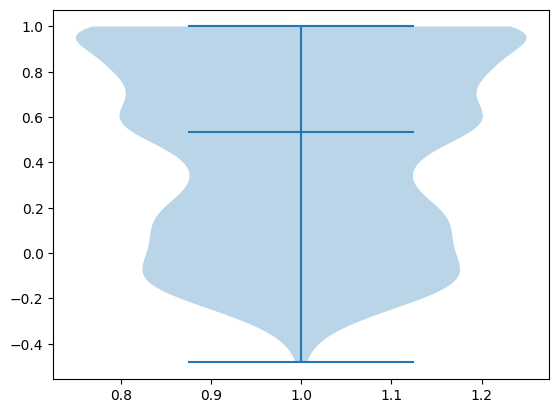

In [76]:
spearman_r2s = compute_spearman_r2s(healthy_sample_results.transpose().to_numpy(), healthy_pseudobulk_results.transpose().to_numpy())
print(f'Median Spearman correlation: {np.median(spearman_r2s)}')
plt.violinplot(spearman_r2s, quantiles=[0.5])
plt.show()